# About
Roughwork for an MS plot function. (Max divided by sum).

See end of this notebook for the main workings.

In [1]:
import sys; sys.path.insert(0, '../')

In [2]:
import pandas as pd
import numpy as np

import fattails.metrics as fattails

# Setup

##### Load Data

In [3]:
data_source = 'https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=-315619200&period2=1577836800&interval=1d&events=history&includeAdjustedClose=true'

price_data = pd.read_csv(data_source)
price_data = price_data.set_index('Date')
price_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1960-01-04,59.910000,59.910000,59.910000,59.910000,59.910000,3990000
1960-01-05,60.389999,60.389999,60.389999,60.389999,60.389999,3710000
1960-01-06,60.130001,60.130001,60.130001,60.130001,60.130001,3730000
1960-01-07,59.689999,59.689999,59.689999,59.689999,59.689999,3310000
1960-01-08,59.500000,59.500000,59.500000,59.500000,59.500000,3290000


##### Calculate Returns

In [4]:
close_price = price_data.Close
previous_close_price = price_data.Close

daily_return = close_price / previous_close_price.shift(1) - 1

# Format as a DataFrame
df = daily_return.to_frame('daily_return') 
df

,daily_return
Date,
1960-01-04,NaN
1960-01-05,0.008012
1960-01-06,-0.004305
1960-01-07,-0.007318
1960-01-08,-0.003183
...,...
2019-12-24,-0.000195
2019-12-26,0.005128
2019-12-27,0.000034


In [5]:
# Remove NaN value
assert df.daily_return.isna().sum() == 1 # The first day has no prior day so return is NaN
df.dropna(inplace=True)

# 2. Check for Power Law
Check the right tail for Power Law behaviour.

Power laws are straight on loglog plots. We'll plot the empirical right tail and check for this behaviour.

In [6]:
# Calculate survival probability for each datapoint
df['survival_probability'] = fattails.get_survival_probability(df.daily_return)
#df = df.sort_values(by='daily_return') # show sorted values
df

,daily_return,survival_probability
Date,,
1960-01-05,0.008012,0.152364
1960-01-06,-0.004305,0.753940
1960-01-07,-0.007318,0.843862
1960-01-08,-0.003183,0.708251
1960-01-11,-0.012269,0.925771
...,...,...
2019-12-24,-0.000195,0.541716
2019-12-26,0.005128,0.246259
2019-12-27,0.000034,0.526619


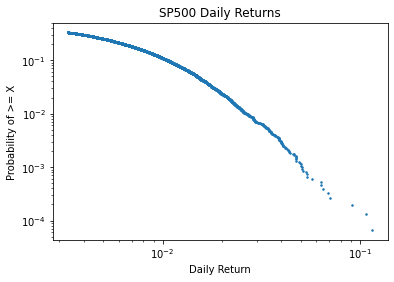

In [7]:
# Plot the Right Tail
selection = df.survival_probability < 0.33 # select top 33% of datapoints

right_tail = df.loc[selection]

right_tail.plot(x='daily_return', y='survival_probability',
                xlabel='Daily Return', ylabel='Probability of >= X', title='SP500 Daily Returns',
                s = 1.5**2,
                kind='scatter', loglog=True); # xlabel argument requires pandas >= 1.2.0

In [8]:
sr = df.daily_return
sr

Date
1960-01-05    0.008012
1960-01-06   -0.004305
1960-01-07   -0.007318
1960-01-08   -0.003183
1960-01-11   -0.012269
                ...   
2019-12-24   -0.000195
2019-12-26    0.005128
2019-12-27    0.000034
2019-12-30   -0.005781
2019-12-31    0.002946
Name: daily_return, Length: 15101, dtype: float64

<AxesSubplot:xlabel='Date'>

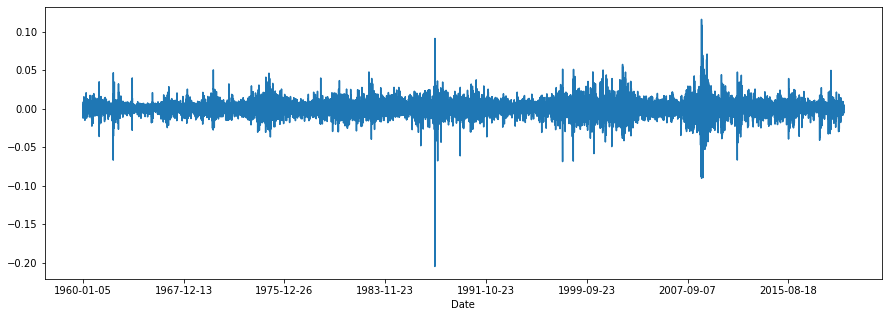

In [9]:
sr.plot(figsize=[15,5])

In [20]:
def calculate_moments(data, moments=[1,2,3,4], absolute_values=True):
    """Create dataframe with a column for each moment.

    Parameters
    ----------
    data : array-like
        Numeric values whose moments you want to calculate.
        Must be 1-dimensional
    
    moments : list-like of numbers
        Each moment has its own column in the output.

    absolute_values : , default True
    
    
    Returns
    -------
    moments_df : DataFrame
        Elementwise evaluation of x**p for each x in data and p in moments
        Number of rows = len(data)
        Number of columns = len(moments)        
    """
    
    # FORMAT THE INPUT
    sr = pd.Series(data)
    if absolute_values:
        # Take absolute values (this matters for odd moments)
        sr = sr.abs()

    # CALCULATE MOMENTS
    df = pd.DataFrame()
    ## Add columns with the moments for each datapoint
    for moment in moments:
        df[f'moment_{moment}']  = sr**moment
    
    return df

In [51]:
def max_over_sum(data):
    """Calculate cumulative max over sum
    
    Parameters
    ----------
    data : array-like
        Numeric values whose moments you want to calculate.
        Must be 1-dimensional

    Returns
    -------
    max_over_sum : Series
        Series with cumulative maximum divided by cumulative sum.
        Cumulative sample size is assigned as the series' index.   
    """
    sr = pd.Series(data)
    
    # Replace index with Cumulative Sample Size
    sr.reset_index(drop=True, inplace=True)
    sr.index += 1
    sr.index.rename('cumulative_sample_size', inplace=True)

    # Calculate
    max_over_sum = sr.cummax()/sr.cumsum()

    return max_over_sum

In [52]:
a = pd.Series(range(1,10+1), name='num')

In [53]:
moments_df = calculate_moments(a)
moments_df

,moment_1,moment_2,moment_3,moment_4
0,1,1,1,1
1,2,4,8,16
2,3,9,27,81
3,4,16,64,256
4,5,25,125,625
5,6,36,216,1296
6,7,49,343,2401
7,8,64,512,4096
8,9,81,729,6561
9,10,100,1000,10000


In [57]:
max_over_sum_df = moments_df.apply(max_over_sum)
max_over_sum_df

,moment_1,moment_2,moment_3,moment_4
cumulative_sample_size,,,,
1,1.000000,1.000000,1.000000,1.000000
2,0.666667,0.800000,0.888889,0.941176
3,0.500000,0.642857,0.750000,0.826531
4,0.400000,0.533333,0.640000,0.723164
5,0.333333,0.454545,0.555556,0.638407
6,0.285714,0.395604,0.489796,0.569670
7,0.250000,0.350000,0.437500,0.513473
8,0.222222,0.313725,0.395062,0.466940
9,0.200000,0.284211,0.360000,0.427901


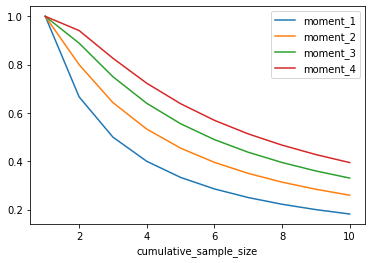

In [61]:
max_over_sum_df.plot();#subplots=True);